##Notebook 2 : Training from scratch using Bi-Directional LSTM

This series of notebooks demonstrates a comparative approach to fake news detection using natural language processing (NLP) techniques. We will use a dataset from Kaggle containing labeled news articles as real or fake.



### Ensuring TensorFlow Version 2.15
This code installs TensorFlow version 2.15.0 and tensorflow-text 2.15.0 using pip. This specific version might be required for compatibility with the code in this notebook. Errors during installation can be ignored.

In [1]:
!pip -q install tensorflow==2.15.0
!pip -q install tensorflow-text==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.67 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.4 MB/s eta 0:00:00

### Importing Necessary Libraries
This code imports the required libraries for data processing, model building, and visualization. These libraries include NumPy, Pandas, re, nltk, gdown, json, io, scikit-learn components, TensorFlow components, and Matplotlib.

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import gdown
import json
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Downloading the Preprocessed Dataset
This Code downloads the preprocessed dataset using `git clone`. The dataset is assumed to be processed in a previous notebook and is stored in a github repository.

In [4]:
!git clone https://github.com/starryendymion/ML-GP1-Monsoon-2024-SOEJNU
%cd 'ML-GP1-Monsoon-2024-SOEJNU'

Cloning into 'ML-GP1-Monsoon-2024-SOEJNU'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16 (from 1)
Receiving objects: 100% (16/16), 91.95 MiB | 14.14 MiB/s, done.


### Loading Features and Labels
This cell loads the features and labels from the downloaded dataset file (`data.npz`).  `features` likely contains the text data, and `labels` contains the corresponding target variables (e.g., sentiment labels).

In [6]:
loaded_data = np.load("processed_dataset/data.npz")
features=loaded_data["features"]
labels=loaded_data["labels"]

### Text Preprocessing: Lemmatization and Cleaning
This code preprocesses the text data by lemmatizing words and removing stop words. Lemmatization reduces words to their base form, and removing stop words eliminates common words that don't carry much meaning. This step helps improve model performance.

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

features = [preprocess_text(text) for text in features]

In [8]:
features[0]

'vote trump went canada immigration site went hard break well sad say sure chance next president beloved united state america going donald trump disappointing say least country could actually elect man like however electoral college mostly spoken much point people america voted trump trying escape realize done vain escape mean fleeing canada large quantity successfully caused canada immigration crash right even unofficial result know something gotta give best part first time canada website crashed desperate american super tuesday site crashed also google search move canada spiked significantly canada reputation nice nice responded advertisement test drive canada something big surprise despise mr trump would look toward friendly northern neighbour great healthcare welfare friendly obama forget maple syrup love one little problem everyone leaving though le people america still stand trump want country u want stay thwart new orange president every chance get le u well le thwarted love ame

### Tokenization and Padding
This code tokenizes the preprocessed text and pads the sequences to a uniform length. Tokenization converts words into numerical representations, and padding ensures all sequences have the same length, which is required for inputting data into the neural network. The tokenizer is saved for later use during inference.

In [9]:
vocab_size = 10000  # Define vocabulary size
max_length = 300   # Define max sequence length

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(features)
sequences = tokenizer.texts_to_sequences(features)

padded_features = pad_sequences(sequences, maxlen=max_length, padding='post')

In [10]:
print(padded_features.shape)

(5562, 300)


In [11]:
padded_features

array([[  42,    1,  295, ...,    0,    0,    0],
       [   4, 1160,  946, ...,    0,    0,    0],
       [   1, 3621, 2697, ...,    0,    0,    0],
       ...,
       [  94,   20, 1811, ...,    0,    0,    0],
       [2800,  954,  418, ...,    0,    0,    0],
       [ 190,  497,  132, ...,    0,    0,    0]], dtype=int32)

In [12]:
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

### Data Splitting
This code splits the data into training and testing sets using `train_test_split`. This division allows us to evaluate the model's performance on unseen data.

In [13]:
# Convert labels to numpy array
labels = np.array(labels)

# Shuffle and split data
padded_features, labels = shuffle(padded_features, labels, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(padded_features, labels, test_size=0.2, random_state=42)

### Model Building and Compilation
This code defines the model architecture, which is a Bidirectional LSTM network. The model is compiled with the 'adam' optimizer, 'binary_crossentropy' loss function (suitable for binary classification), and 'accuracy' as the evaluation metric. A summary of the model is printed.

In [14]:
embedding_dim = 384

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 384)          3840000   
                                                                 
 bidirectional (Bidirection  (None, 300, 128)          229888    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 3

### Early Stopping Callback
This code defines an EarlyStopping callback to prevent overfitting. Training will stop if the validation accuracy doesn't improve for a certain number of epochs (patience).

In [15]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

### Model Training
This Code trains the model using the training data and validates it on the testing data. The training process runs for a specified number of epochs with a defined batch size. The EarlyStopping callback is used to monitor validation accuracy and potentially stop training early.

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/20
70/70 [==============================] - 21s 154ms/step - loss: 0.2145 - accuracy: 0.9191 - val_loss: 0.0112 - val_accuracy: 0.9973
Epoch 2/20
70/70 [==============================] - 9s 128ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0089 - val_accuracy: 0.9982
Epoch 3/20
70/70 [==============================] - 9s 125ms/step - loss: 5.3678e-04 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 0.9982
Epoch 4/20
70/70 [==============================] - 6s 89ms/step - loss: 2.7942e-04 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 0.9982
Epoch 5/20
70/70 [==============================] - 8s 117ms/step - loss: 1.7340e-04 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9982
Epoch 6/20
70/70 [==============================] - 6s 82ms/step - loss: 1.1878e-04 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.9982
Epoch 7/20
70/70 [==============================] - 7s 94ms/step - loss: 8.6199e-05 - accuracy: 1.0000 - val_loss: 0.0097 - val_accur

### Model Saving and Visualization
This code saves the trained model to a file named "bidirectional-lstm-model.h5". It also generates plots to visualize the training and validation accuracy and loss over epochs. These plots help in understanding the model's learning process.

In [17]:
model.save("bidirectional-lstm-model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


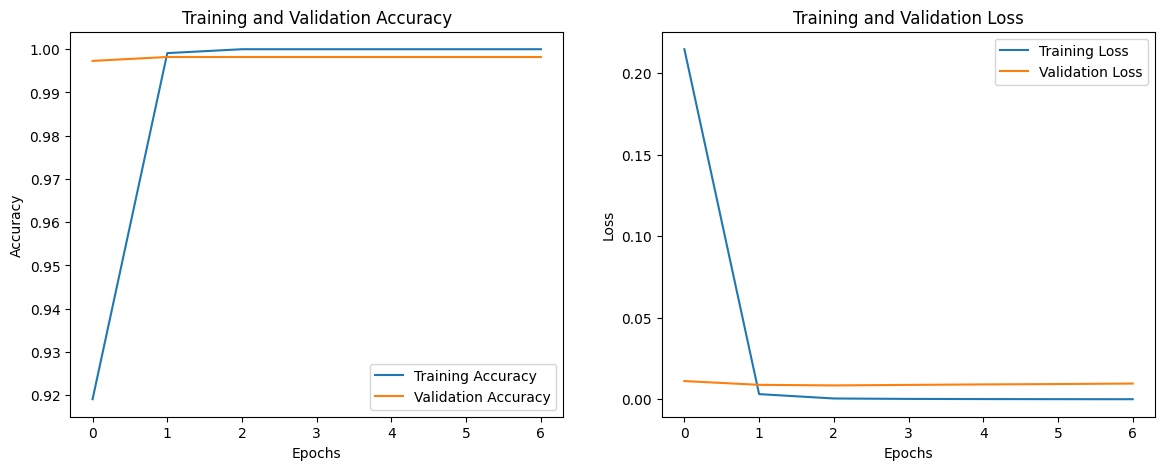

In [18]:
 # Plot accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


35/35 [==============================] - 1s 18ms/step


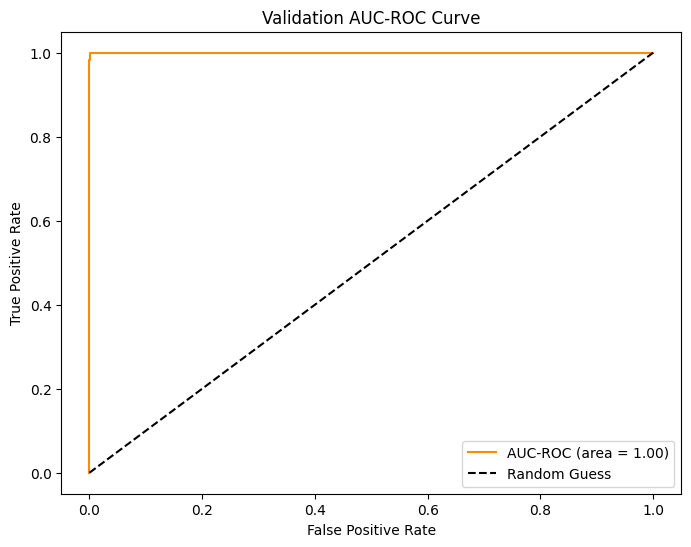

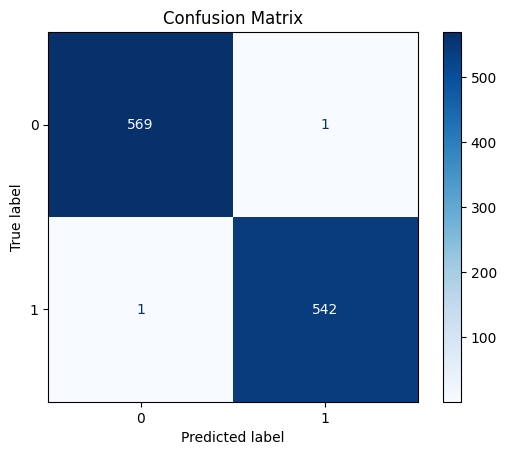

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Get model predictions for AUC-ROC curve
y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plotting the AUC-ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {auc_score:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation AUC-ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Get binary predictions for confusion matrix
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()